In [78]:
import pathlib
import requests

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, dummy, linear_model, model_selection
from sklearn import metrics, multioutput, pipeline, preprocessing, utils

# Binary Classification

# MNIST Dataset

The original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset consists of 70000 28x28 black and white images in 10 classes. There are 60000 training images and 10000 test images.

In [2]:
# might be different if using Colab or Kaggle
PROJECT_ROOT_DIR = pathlib.Path(".")

DATA_DIR = PROJECT_ROOT_DIR / "data" / "mnist"
DATA_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT_DIR / "results" / "mnist"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


### Download and extract the data (if using Colab or Kaggle!)

In [3]:
URL = "https://github.com/davidrpugh/machine-learning-for-tabular-data/blob/main/data/mnist/mnist.parquet?raw=true"

with open(DATA_DIR / "mnist.parquet", 'wb') as f:
    response = requests.get(URL)
    f.write(response.content)


In [4]:
%%bash
ls -lh ./data/mnist

total 21M
-rw-r--r-- 1 root root 21M Nov 27 06:29 mnist.parquet


## Load the data

We will load the data using the [Pandas](https://pandas.pydata.org/) library. Highly recommend the most recent edition of [*Python for Data Analysis*](https://learning.oreilly.com/library/view/python-for-data/9781491957653/) by Pandas creator Wes Mckinney for anyone interested in learning how to use Pandas.

In [5]:
data = pd.read_parquet(DATA_DIR / "mnist.parquet")
features = data.drop("label", axis=1)
target = data.loc[:, "label"]

## Explore the data

In [6]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 52.3 MB


In [7]:
features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
features.tail()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
69995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


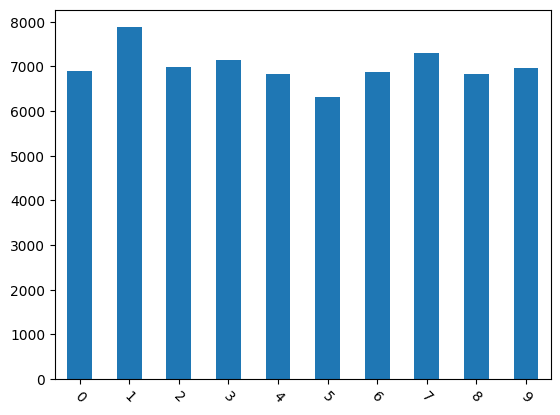

In [10]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))
_ = plt.xticks(rotation=-45)

## Visualize the data

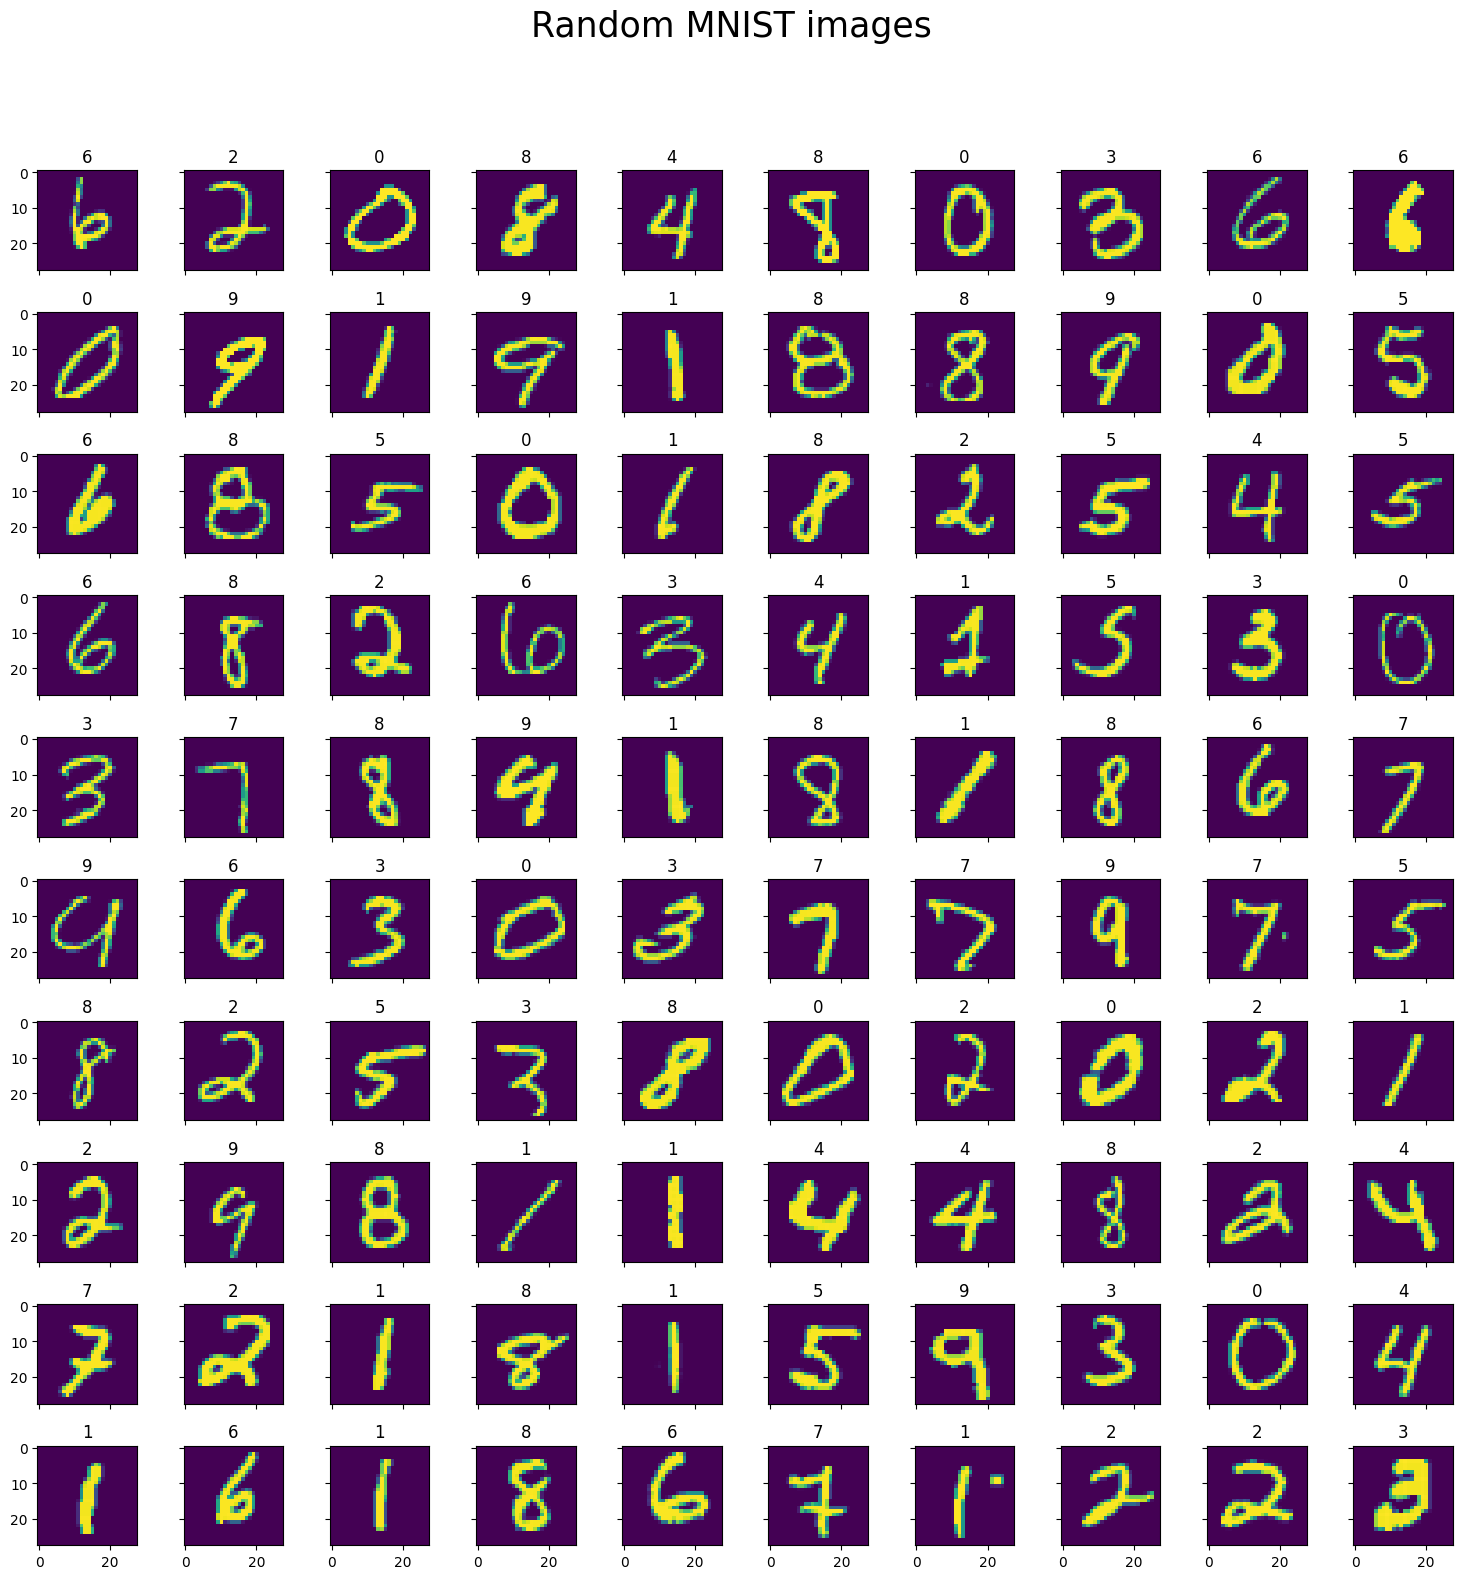

In [11]:
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        m, _ = features.shape
        k = np.random.randint(m)
        img = (features.loc[k, :]
                       .to_numpy()
                       .reshape((28, 28)))
        _ = axes[i, j].imshow(img)
        _ = axes[i, j].set_title(target.iloc[k])

fig.suptitle("Random MNIST images", x=0.5, y=1.05, fontsize=25)
fig.tight_layout()

# Look at the Big Picture

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to build a tool for reading electricity meter serial numbers which consist of sequences of sometimes handwritten digits. Part of this tool will be a model that can correctly classify individual handwritten digits. Our image classication model is just one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to read off the electricity meter serial numbers.

### What is the current solution?

Always a good idea to know what the current solution to the problem you are trying to solve. Current solution gives a benchmark for performance. Note that the current "best" solution could be very simple or could be very sophisticated. Understanding the current solution helps you think of a good place to start. Example: suppose that the current solution for predicting the price of a house in a given census block is to ignore all the demographic information and predict a simple average of house prices in nearby census blocks. In this case it would probably not make sense to start building a complicated deep learning model to predict housing prices. However, if the current solution was a tuned gradient boosted machine then it probably would not make sense to try a much simpler linear regression model.

With all this information, you are now ready to start designing your system. First, you need to frame the problem by answering the following questions.

* Is our problem supervised, unsupervised, or reinforcement learning?
* Is our problem a classification task, a regression task, or something else? If our problem is a classification task are we trying to classify samples into 2 categories (binary classification) or more than 2 (multi-class classification) categories? If our problem is a regression task, are we trying to predict a single value (univariate regression) or multiple values (multivariate regression) for each sample?
* Should you use batch learning or online learning techniques?


### Exercise: Selecting a metric

Scikit-Learn has a number of different [possible metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) that you can choose from (or you can create your own custom metric if required). Can you find a few metrics that seems appropriate for our image classification model?

# Creating a Test Dataset

Before we look at the data any further, we need to create a test set, put it aside, and never look at it (until we are ready to test our trainined machine learning model!). Why? We don't want our machine learning model to memorize our dataset (this is called overfitting). Instead we want a model that will generalize well (i.e., make good predictions) for inputs that it didn't see during training. To do this we hold split our dataset into training and testing datasets. The training dataset will be used to train our machine learning model(s) and the testing dataset will be used to make a final evaluation of our machine learning model(s).


## If this is all the data you will ever have...

...then you can just set a seed for the random number generator and then randomly split the data. Scikit-Learn has a [`model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module that contains tools for splitting datasets into training and testing sets.

In [ ]:
model_selection.train_test_split?

In [12]:
SEED = 42
SEED_GENERATOR = np.random.RandomState(SEED)


def generate_seed():
    return SEED_GENERATOR.randint(np.iinfo("uint16").max)

In [13]:
TEST_SIZE = 1e-1

# split the dataset into training and testing data
_seed = generate_seed()
_random_state = np.random.RandomState(_seed)
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    stratify=target,
    random_state=_random_state
)

In [14]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63000 entries, 29990 to 43298
Columns: 784 entries, pixel1 to pixel784
dtypes: uint8(784)
memory usage: 47.6 MB


In [15]:
train_features.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
29990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_target.head()

29990    2
67438    6
22891    7
55259    0
18172    5
Name: label, dtype: uint8

In [17]:
train_features.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,63000.0,...,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.000000,63000.0,63000.0,63000.0,63000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.199524,0.104095,0.051111,0.017778,0.010524,0.000921,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.005698,4.401675,2.929272,1.637365,1.318174,0.231078,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,58.000000,0.0,0.0,0.0,0.0


Again, if you want to you can write out the train and test sets to disk to avoid having to recreate them later.

In [18]:
_ = (train_features.join(train_target)
                   .to_parquet(DATA_DIR / "train.parquet", index=False))

_ = (test_features.join(test_target)
                   .to_parquet(DATA_DIR / "test.parquet", index=False))

## Training a Binary Classifier

In [41]:
estimator = linear_model.LogisticRegression()
_ = estimator.fit(train_features, train_target == 5)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
estimator.predict(train_features)

array([False, False, False, ..., False, False, False])

In [43]:
train_target == 5

29990    False
67438    False
22891    False
55259    False
18172     True
         ...  
25693    False
3033     False
18713    False
42417    False
43298    False
Name: label, Length: 63000, dtype: bool

In [44]:
train_target.iloc[0]

2

In [45]:
train_target.iloc[4]

5

Congrats! You have fit your first machine learning model using Scikit-Learn and made some predictions. Now let's see how good those predictions really are.

# Evaluate your models on the test dataset

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. First, we need to re-fit the pipeline using the full training data set.

In [107]:
_ = ml_pipeline.fit(train_features, train_target)

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   0.6s
[Pipeline]  (step 2 of 2) Processing dropuselessfeatures, total=   0.8s
[Pipeline] .......... (step 1 of 2) Processing pipeline, total=   1.3s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=  22.2s


In [108]:
# make predictions
test_predictions = ml_pipeline.predict(test_features)

# generate a classification report
_report = metrics.classification_report(
    test_target,
    test_predictions,
)
print(_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       690
           1       0.96      0.98      0.97       788
           2       0.93      0.91      0.92       699
           3       0.90      0.89      0.90       714
           4       0.93      0.95      0.94       682
           5       0.89      0.87      0.88       631
           6       0.95      0.96      0.96       688
           7       0.94      0.93      0.93       729
           8       0.90      0.89      0.90       683
           9       0.89      0.90      0.90       696

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000



Finally, we can save our trained model to disk for later use.

In [109]:
_ = joblib.dump(ml_pipeline, RESULTS_DIR / "linear-model.pkl")